# Time Series Modeling

In [1]:
import pandas as pd
import numpy as np
import os, glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import joblib

from datetime import datetime, timedelta
sns.set(style="whitegrid", font_scale=1)

In [2]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week #ofyear
    
    X = df[['dayofweek','quarter', 'month', 'weekofyear']]
    
   # X = df[['hour','dayofweek','quarter','month','year',
   #        'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

# Load data

## The original (cleaned) data

In [295]:
## Hourly Energy Demand
# fileName_to_load = "data/energy.pkl"
# with open(fileName_to_load, 'rb') as fp:
#     data = pickle.load(fp)

# data.keys()

In [6]:
## Data with NaN
#energy_data = data['with_na']

## Data after imputing NaN
#df = data['fill_na']

In [294]:
#display(energy_data.head(5).T)
#display(df.head(5).T)

## Feature engineered data

In [3]:
## Load feature engineered data
df = pd.read_csv('data/energy_feat.csv')

# convert the column (it's a string) to datetime type
df['time'] = pd.to_datetime(df['time'],
                          errors='coerce',
                          infer_datetime_format=True, utc=True
                          ).dt.tz_convert(None) + timedelta(hours=1)
# check the data type
df.dtypes

time                                           datetime64[ns]
generation biomass                                    float64
generation fossil brown coal/lignite                  float64
generation fossil gas                                 float64
generation fossil hard coal                           float64
generation fossil oil                                 float64
generation hydro pumped storage consumption           float64
generation hydro run-of-river and poundage            float64
generation hydro water reservoir                      float64
generation nuclear                                    float64
generation other                                      float64
generation other renewable                            float64
generation solar                                      float64
generation waste                                      float64
generation wind onshore                               float64
forecast solar day ahead                              float64
forecast

In [4]:
# create datetime index passing the datetime series
df.set_index('time', inplace=True)

# check the index
df.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq=None)

## EDA (hourly energy load)

* The `total load actual` has a repeated pattern for every 24 hours.
* It also shows the weekly and mothely oscillations.
* Thus, this time series (`total load actual`) has **multiple seasonality**.

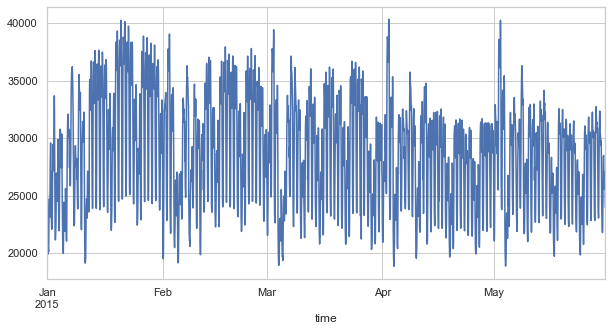

In [5]:
## df.sort_index(inplace=True)
temp = df['total load actual'].resample('1h').mean()

_ = temp.iloc[:24*150].plot(figsize=(10,5))

### Lag Features: Examine the `acf`, `pacf` plot

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

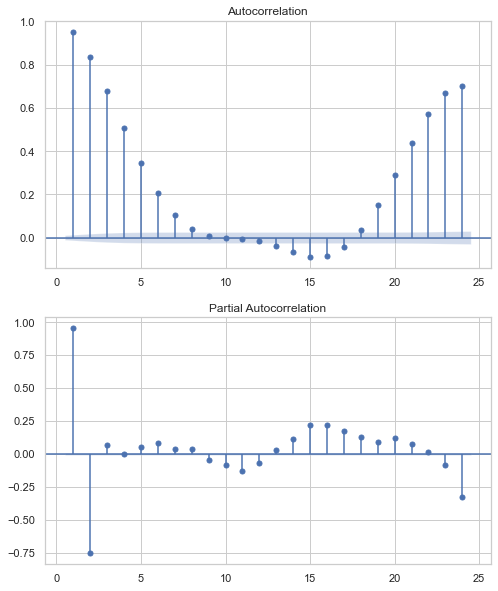

In [7]:
# Estimate seasonal (P, D, Q, S)

# Examine the hourly lags
input_data = df['total load actual']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, lags=24, zero=False, ax=ax1)
plot_pacf(input_data, lags=24, zero=False, ax=ax2)
plt.show()

# Seasonal period S = 24 (hrs)

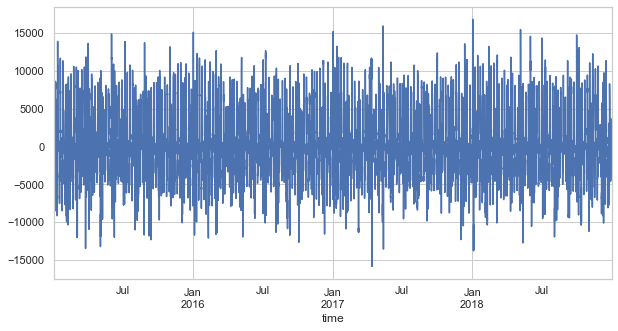

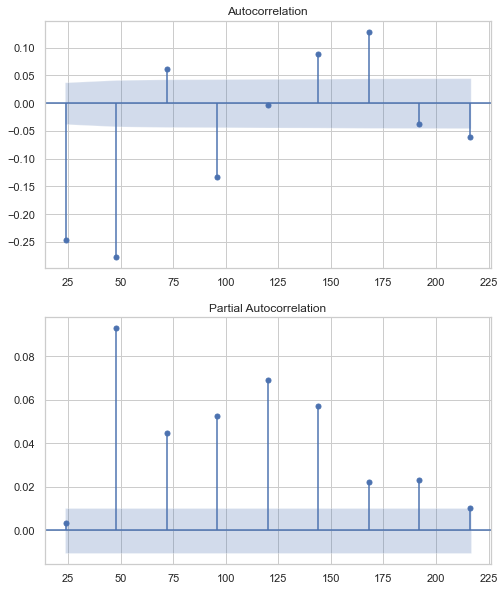

In [18]:
# Examine the lags of differences between 24 hours 
input_data = df['total load actual'].diff(24).dropna() #df['total load actual']
lags = np.arange(24, 240, 24)

input_data.plot(figsize=(10,5))
plt.show()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.show()

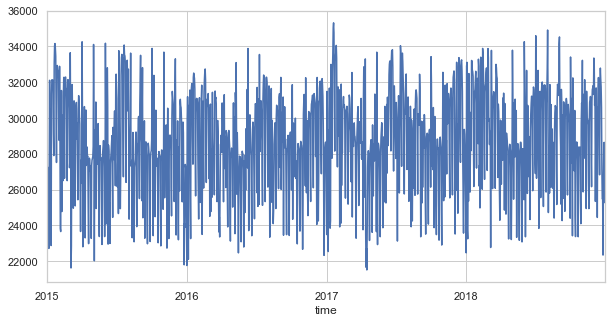

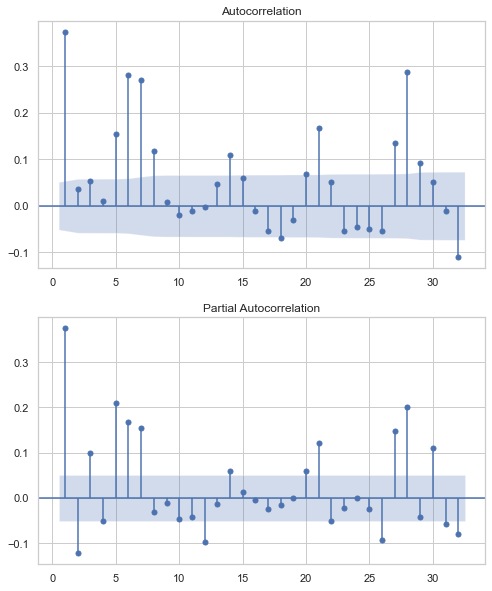

In [20]:
# Examine the daily lags
input_data = df['total load actual'].resample('1D').mean()
_ = input_data.plot(figsize=(10,5))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, zero=False, ax=ax1)
plot_pacf(input_data, zero=False, ax=ax2)
plt.show()

# there's a seasonal period of 7 days.

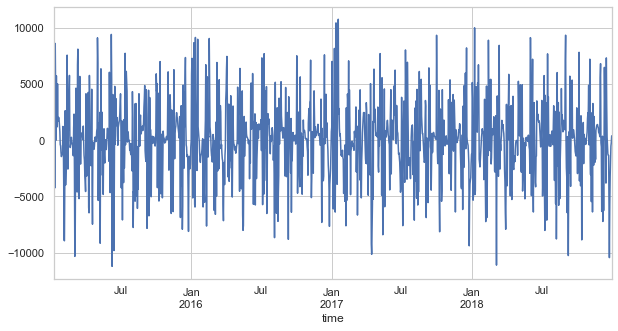

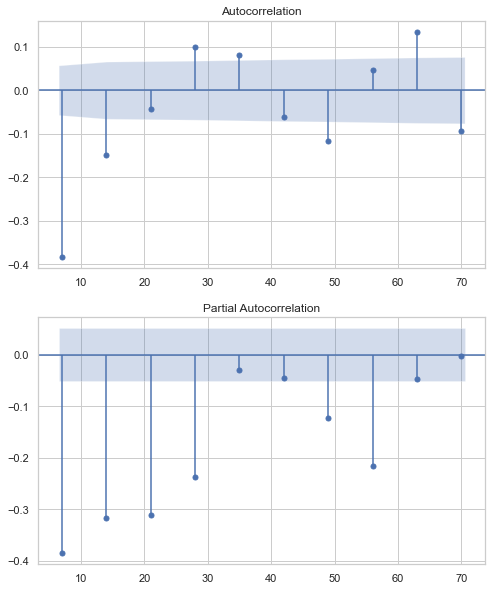

In [27]:
# Examine the lags of 7 day differences
input_data = df['total load actual'].resample('1D').mean().diff(7).dropna()
_ =input_data.plot(figsize=(10,5))

lags = np.arange(7, 77, 7)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.show()


### Seasonal decomposition (hourly)

In [252]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [253]:
temp = df['total load actual'].resample('1h').mean()

Check the seasonal decomposition wiith the period of 24 hours. Here, I use the first 3 years data. The last year (2018) is the holdout set and won't be used for training.

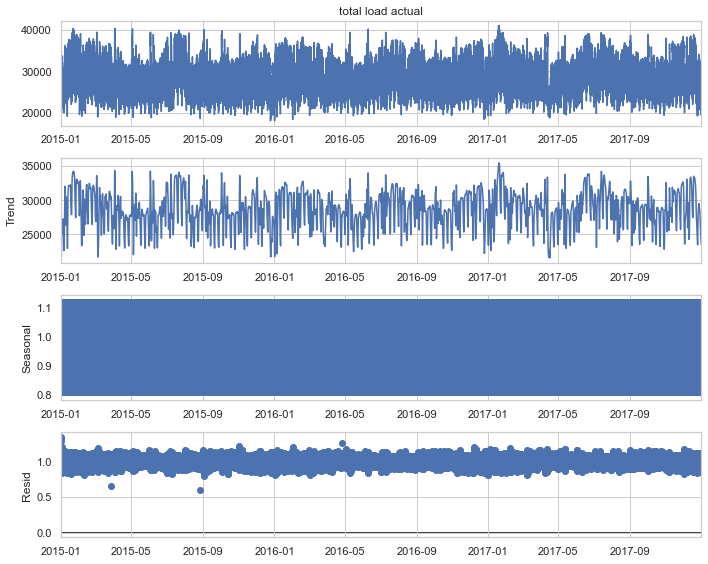

In [247]:
# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(temp.loc[:'2017'], 
                                          model='multiplicative',
                                          extrapolate_trend='freq', period=24)

plt.rcParams['figure.figsize'] = (10, 8)
ax = decomposition.plot()

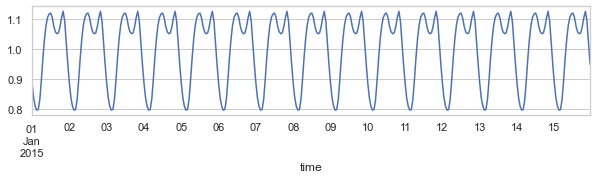

In [248]:
# Cheack the daily pattern (seasonal component)
_ = decomposition.seasonal.iloc[:360].plot(figsize=(10,2))

* For each day, its hourly osillation has a stereotype (general pattern).
* Thus, we can focus on forcasting the _daily_ **Max** and **Min** loads.

## Feature extract (daily Max/Min load)

We extract the daily min, max load from the original time series.

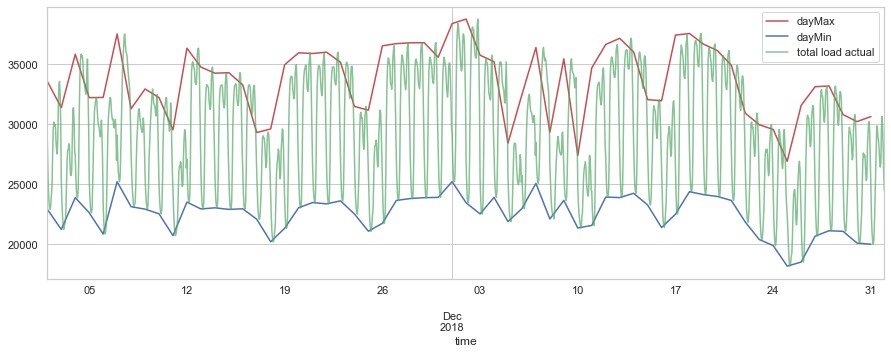

In [6]:
# day_max = (df.resample('12h')[[
#     'total load actual'
# ]].max()).resample('1d').mean().rename(columns={'total load actual': 'dayMax'})
#day_max.index = day_max.index+timedelta(hours=12)

day_max = (df.resample('1d')[[
    'total load actual'
]].max()).rename(columns={'total load actual':'dayMax'})

day_min = df.resample('1d')[[
    'total load actual'
]].min().rename(columns={'total load actual': 'dayMin'})

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
day_max.iloc[-60:].plot(ax=ax, color='r')
day_min.iloc[-60:].plot(ax=ax, color='b')
df[['total load actual']].iloc[-60 * 24:].plot(ax=ax, color='g', alpha=0.7)
plt.show()

In [7]:
day_min_max = day_min.join(day_max)
day_min_max.head()

,dayMin,dayMax
time,,
2015-01-01,19905.0,29571.0
2015-01-02,22066.0,33668.0
2015-01-03,21145.0,29874.0
2015-01-04,21929.0,30772.0
2015-01-05,19964.0,25604.0


In [8]:
#datetime.strptime('2018-01-01', '%y-%m-%d')
_ = create_features(day_min_max)
day_min_max.loc['2018-12-31','weekofyear'] = 53
day_min_max.head()

,dayMin,dayMax,date,dayofweek,quarter,month,weekofyear
time,,,,,,,
2015-01-01,19905.0,29571.0,2015-01-01,3,1,1,1
2015-01-02,22066.0,33668.0,2015-01-02,4,1,1,1
2015-01-03,21145.0,29874.0,2015-01-03,5,1,1,1
2015-01-04,21929.0,30772.0,2015-01-04,6,1,1,1
2015-01-05,19964.0,25604.0,2015-01-05,0,1,1,2


* Smooth the daily data using "half"-Gaussian filter

In [9]:
npl = day_min_max.copy()
smoothed_cases_max = []
smoothed_cases_min = []

for date in sorted(npl['date']):
    d_date = (npl['date'] - date)
    
    npl['gkv'] = np.exp(
        -((d_date.apply(lambda x: x.days)) ** 2) / (2 * (0.75 ** 2))# Gaussian filter
    ) * d_date.apply(lambda x: int(x.days<=0)) # The points before current date, 
                                               # the dates in the future are excluded.
    
    npl['gkv'] /= npl['gkv'].sum()
    smoothed_cases_max.append(round(npl['dayMax'] * npl['gkv']).sum())
    smoothed_cases_min.append(round(npl['dayMin'] * npl['gkv']).sum())

day_min_max['smoothed_dayMax'] = smoothed_cases_max
day_min_max['smoothed_dayMin'] = smoothed_cases_min


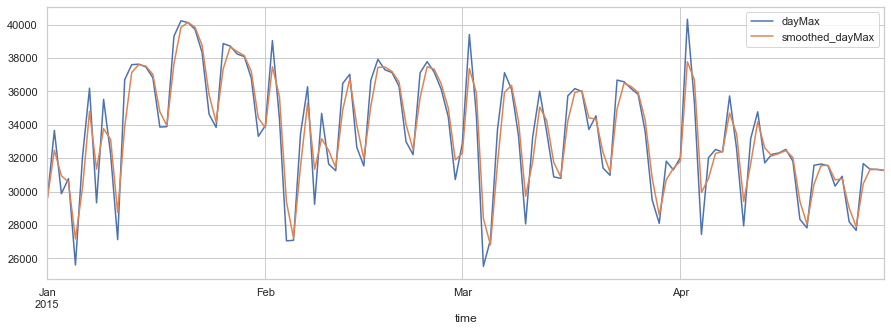

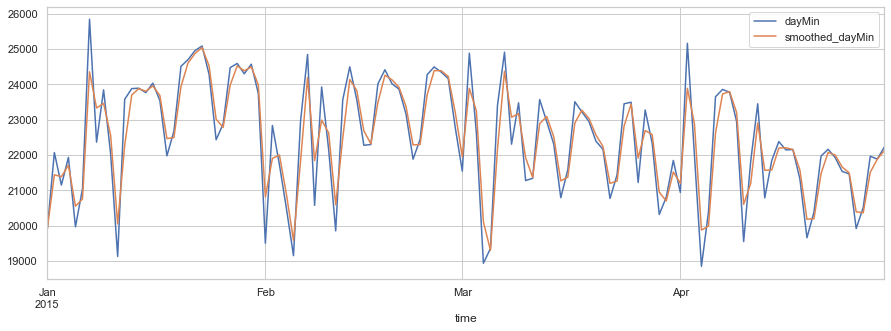

In [10]:
# Plot the daily Max/Min before/after curve smoothing

day_min_max[['dayMax','smoothed_dayMax']].iloc[:120].plot(figsize=(15,5))
plt.show()

day_min_max[['dayMin','smoothed_dayMin']].iloc[:120].plot(figsize=(15,5))
plt.show()

## EDA (daily Max/Min energy load)

### Stationarity (by day)

In [11]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    '''
    Null Hypothesis: The series has a unit root (non-stationary).
    Alternate Hypothesis: The series has no unit root.
    '''
    print("Results of Dickey-Fuller Test: [Null - has a unit root]")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    '''
    Null Hypothesis: The process is trend stationary.
    Alternate Hypothesis: The series has a unit root (series is not stationary).
    
    Code adopt from
    https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
    '''
    print ('Results of KPSS Test: [Null - stationary]')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

* Case 1: Both tests conclude that the series is not stationary - The series is not stationary
* Case 2: Both tests conclude that the series is stationary - The series is stationary
* Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
* Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [34]:
kpss_test(day_min_max['dayMax'].diff().dropna())
print('\n')
adf_test(day_min_max['dayMax'].diff().dropna())

print('\n\n')
kpss_test(day_min_max['dayMax'].loc['2018':].dropna())
print('\n')
adf_test(day_min_max['dayMax'].loc['2018':].dropna())

Results of KPSS Test: [Null - stationary]
Test Statistic            0.04443
p-value                   0.10000
Lags Used                70.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


Results of Dickey-Fuller Test: [Null - has a unit root]
Test Statistic                -1.488197e+01
p-value                        1.604368e-27
#Lags Used                     1.900000e+01
Number of Observations Used    1.440000e+03
Critical Value (1%)           -3.434899e+00
Critical Value (5%)           -2.863549e+00
Critical Value (10%)          -2.567840e+00
dtype: float64



Results of KPSS Test: [Null - stationary]
Test Statistic           0.244954
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Results of Dickey-Fuller

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [13]:
kpss_test(day_min_max['smoothed_dayMax'])
print('\n')
adf_test(day_min_max['smoothed_dayMax'])

Results of KPSS Test: [Null - stationary]
Test Statistic            0.225496
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Results of Dickey-Fuller Test: [Null - has a unit root]
Test Statistic                -6.562720e+00
p-value                        8.303686e-09
#Lags Used                     2.100000e+01
Number of Observations Used    1.439000e+03
Critical Value (1%)           -3.434902e+00
Critical Value (5%)           -2.863551e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [14]:
kpss_test(day_min_max['dayMin'])
print('\n')
adf_test(day_min_max['dayMin'])

Results of KPSS Test: [Null - stationary]
Test Statistic            0.735357
p-value                   0.010331
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Results of Dickey-Fuller Test: [Null - has a unit root]
Test Statistic                -6.155954e+00
p-value                        7.368027e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.438000e+03
Critical Value (1%)           -3.434906e+00
Critical Value (5%)           -2.863552e+00
Critical Value (10%)          -2.567841e+00
dtype: float64


In [15]:
kpss_test(day_min_max['smoothed_dayMin'])
print('\n')
adf_test(day_min_max['smoothed_dayMin'])

Results of KPSS Test: [Null - stationary]
Test Statistic            0.737760
p-value                   0.010113
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Results of Dickey-Fuller Test: [Null - has a unit root]
Test Statistic                -6.199121e+00
p-value                        5.865781e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.438000e+03
Critical Value (1%)           -3.434906e+00
Critical Value (5%)           -2.863552e+00
Critical Value (10%)          -2.567841e+00
dtype: float64


### Lag Features: examine the acf, pacf plot

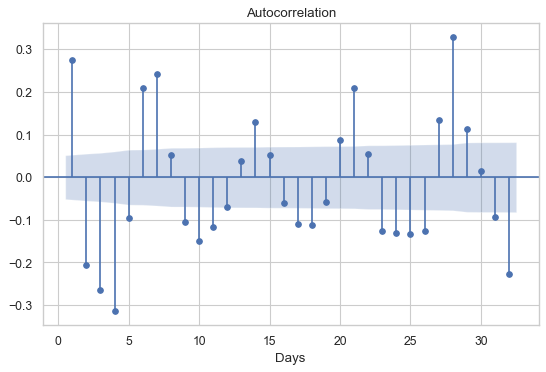

In [16]:
# Find seasonal (P, D, Q, S)

fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=80)

lags = None#np.arange(7, 77, 7)


input_data = day_min_max['dayMax'] - day_min_max['dayMax'].rolling(6).mean()

input_data = input_data.dropna()
plot_acf(input_data, lags=lags, zero=False, ax=ax)
plt.xlabel('Days')
#plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
#plt.savefig('EDA_fig/seasonal_S_ACF.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()

# Seasonal period S = 7 (days)

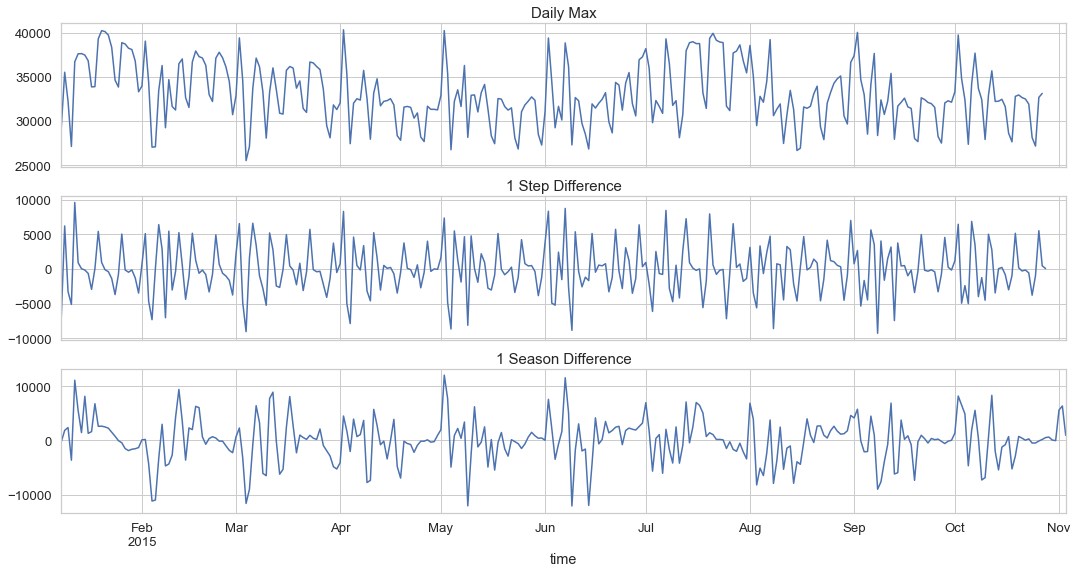

In [174]:
sns.set(style="whitegrid", font_scale=1.2)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(18, 9), sharex=True)

input_data = day_min_max['dayMax']#.diff() #- day_min_max['dayMax'].rolling(7).mean()
input_data.iloc[:300].plot(ax=ax1)
ax1.set_title('Daily Max', fontsize=15)

input_data = day_min_max['dayMax'].diff(1).dropna() #- day_min_max['dayMax'].rolling(10).mean()
input_data.iloc[:300].plot(ax=ax2)
ax2.set_title('1 Step Difference', fontsize=15)


input_data = day_min_max['dayMax'].diff(7).dropna() #- day_min_max['dayMax'].rolling(10).mean()
ax3.set_title('1 Season Difference', fontsize=15)
input_data.iloc[:300].plot(ax=ax3)
#plt.savefig('EDA_fig/diff_1.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()


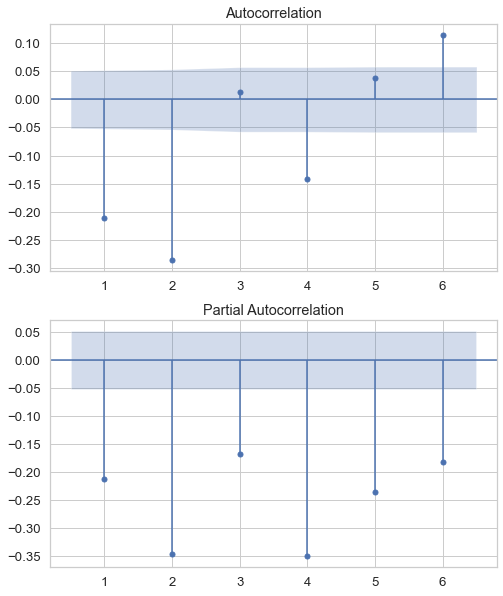

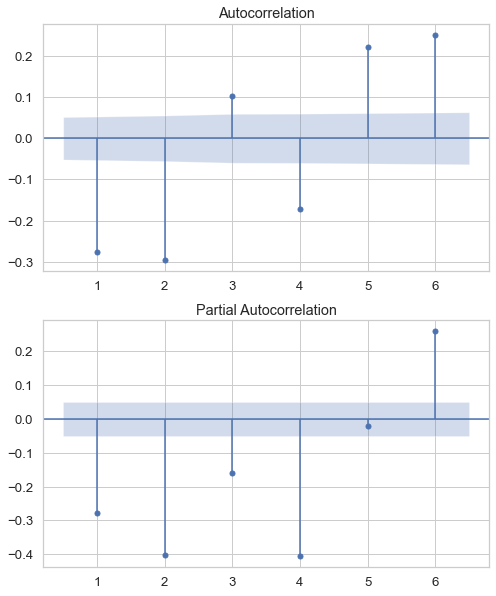

In [184]:

# input_data = day_min_max['dayMax']#.diff(1).dropna()
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
# input_data = input_data.dropna() 
# plot_acf(input_data, lags=6, zero=False, ax=ax1)
# plot_pacf(input_data, lags=6, zero=False, ax=ax2)
# #plt.savefig('EDA_fig/ACF_PACF.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
# plt.show()


input_data = day_min_max['dayMax'].diff()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = input_data.dropna() 
plot_acf(input_data, lags=6, zero=False, ax=ax1)
plot_pacf(input_data, lags=6, zero=False, ax=ax2)
plt.savefig('EDA_fig/ACF_PACF_diff_d_1.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()


input_data = day_min_max['dayMax'].diff(1).diff(7)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = input_data.dropna() 
plot_acf(input_data, lags=6, zero=False, ax=ax1)
plot_pacf(input_data, lags=6, zero=False, ax=ax2)
#plt.savefig('EDA_fig/ACF_PACF_diff_DS_1.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()

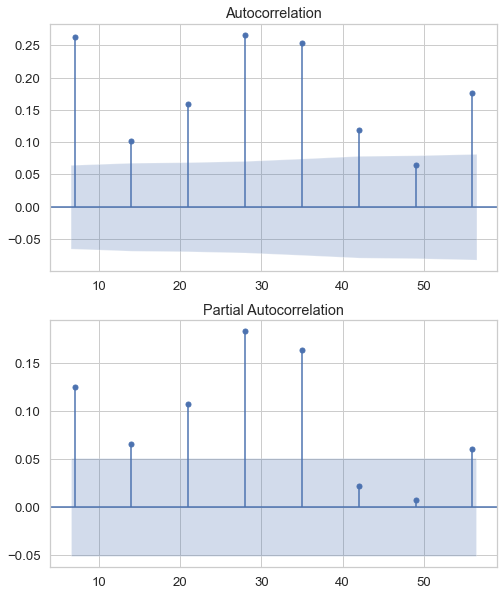

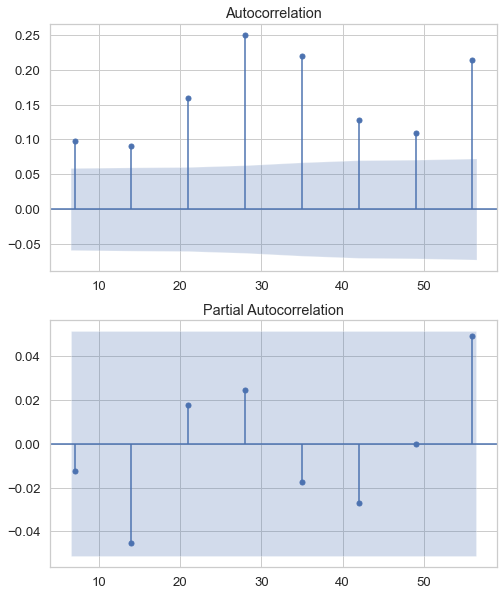

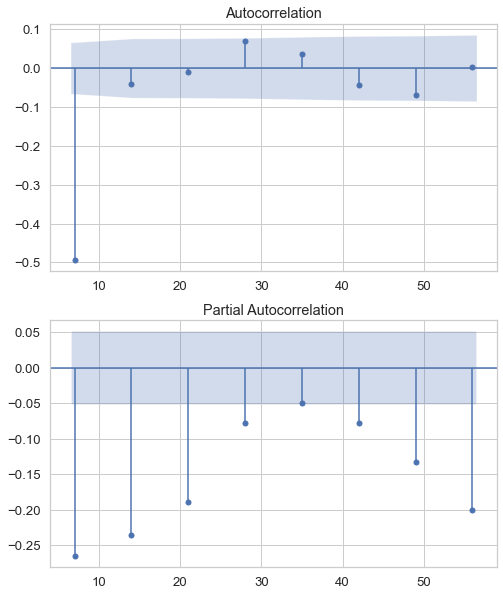

In [189]:
lags = np.arange(7, 57, 7)


input_data = day_min_max['dayMax']#.diff(1).dropna()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = input_data.dropna() 
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.savefig('EDA_fig/ACF_PACF_Season.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()


input_data = day_min_max['dayMax'].diff()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = input_data.dropna() 
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.savefig('EDA_fig/ACF_PACF_Season_diff_d_1.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()


input_data = day_min_max['dayMax'].diff(1).diff(7)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10))
input_data = input_data.dropna() 
plot_acf(input_data, lags=lags, zero=False, ax=ax1)
plot_pacf(input_data, lags=lags, zero=False, ax=ax2)
plt.savefig('EDA_fig/ACF_PACF__Season_diff_DS_1.pdf',dpi=80, pad_inches=0.1, bbox_inches='tight')
plt.show()

# Forecasting using SARIMAX (by day)

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm

In [19]:
def train_test_split_by_time(ind_var, dep_var, dataFrame = day_min_max, forecast_start='2018-01-01',
                             train_start=None,
                             forecast_days=None):
    '''
    train_test_split_by_time - Sep
    
    Split arrays time into train and test subsets
    '''
    
    ## Define the independent (date 'ds'), and dependent variable ('y')
    df = dataFrame.reset_index().rename(
        columns={ind_var: 'ds',
                 dep_var: 'y'  #'smoothed_dayMax': 'y' #'dayMax':'y'
                }).set_index('ds')

    ## Forecast date range (test with 14 days)
    if forecast_days == None:
        forecast_end = None
    else:
        forecast_end = pd.to_datetime(forecast_start) + timedelta(
            days=forecast_days) - timedelta(hours=1)

    ## Training end date (a hour/day before forecast_start)
    #train_start = pd.to_datetime(forecast_start) - timedelta(days=360)
    train_end = pd.to_datetime(forecast_start) - timedelta(hours=1)

    feat_col_sel = [
        'dayofweek', 'month', 'quarter', 'weekofyear', 'y', #'dayMax', 'dayMin', #'dayMax',  #'smoothed_dayMax', 'smoothed_dayMin' 'dayMax', 'dayMin',
    ]
    
    # Train and test sets split
    df_train = df.loc[train_start:train_end][feat_col_sel]
    df_test = df.loc[forecast_start:forecast_end][feat_col_sel]

    return df_train, df_test


## Train-Test split

In [20]:
ind_var = 'time'
dep_var = 'dayMax' #'smoothed_dayMax'#.format('dayMin')

df_train, df_test = train_test_split_by_time(ind_var, dep_var, forecast_start='2018-01-01', forecast_days=90)
    
display(df_train.tail())
display(df_test.head())

,dayofweek,month,quarter,weekofyear,y
ds,,,,,
2017-12-27,2,12,4,52,34058.0
2017-12-28,3,12,4,52,33375.0
2017-12-29,4,12,4,52,32423.0
2017-12-30,5,12,4,52,29365.0
2017-12-31,6,12,4,52,29097.0


,dayofweek,month,quarter,weekofyear,y
ds,,,,,
2018-01-01,0,1,1,1,27534.0
2018-01-02,1,1,1,1,38313.0
2018-01-03,2,1,1,1,38355.0
2018-01-04,3,1,1,1,28770.0
2018-01-05,4,1,1,1,27316.0


## Training

* The order (p,d,q) and seasonal_order (P,D,Q) parameter were searched using auro-arima from pmdarima.arima.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(4, 1, 0)x(3, 1, [1], 7)   Log Likelihood              -10140.250
Date:                             Mon, 22 Nov 2021   AIC                          20298.500
Time:                                     18:04:17   BIC                          20343.429
Sample:                                 01-01-2015   HQIC                         20315.506
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4510      0.022    -20.939      0.000      -0.493      -0.409
ar.L2         -0.5191      

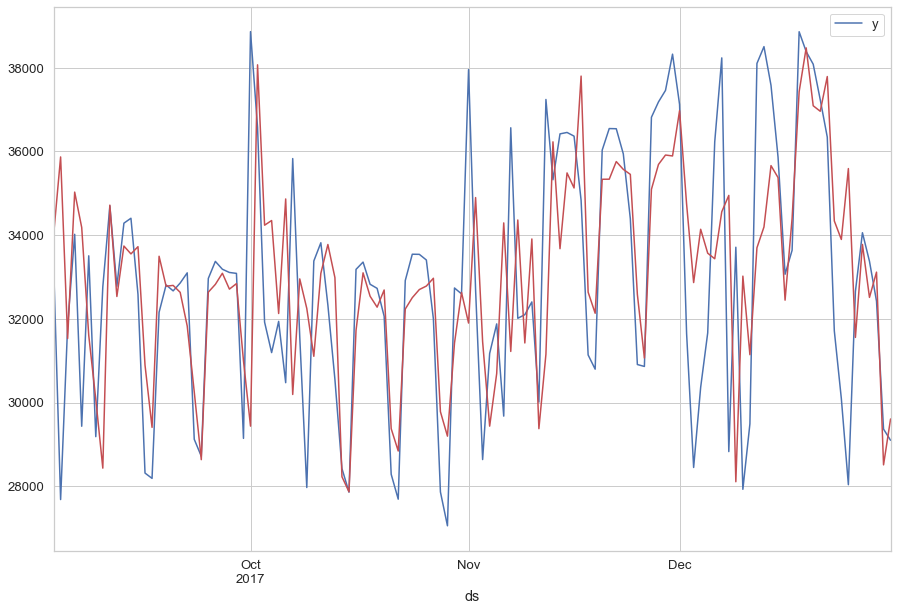

In [305]:
# order=(5,1,0), seasonal_order=(5,1,0,7) for smoothed_dayMax, and smoothed_dayMin

# Remember to change frequency to match the time series data
model = SARIMAX(df_train[['y']], order=(4,1,0), seasonal_order=(3,1,1,7), freq='D') #exog=exogs,
results = model.fit()

## Print summary
print(results.summary())

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
#results.predict().plot(figsize=(10,5))
fig, ax = plt.subplots(figsize=(15,10))
df_train[['y']].iloc[-120:].plot(ax=ax)

results.predict().iloc[-120:].plot(color='r',ax=ax)
#df_test['dayMax'].iloc[:120].plot(color='k',ax=ax)
#df_train['dayMax'].iloc[-120:].plot(color='k',ax=ax)
plt.show()



/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


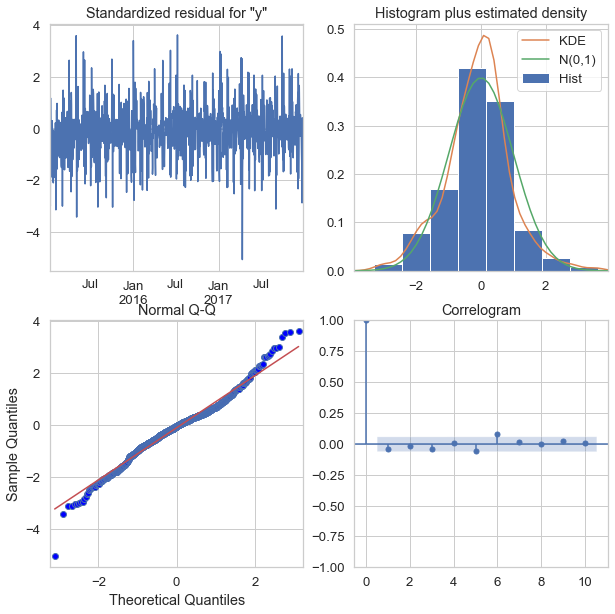

In [307]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(10,10))
#plt.savefig('EDA_fig/{}_SARIMAX_result.pdf'.format(dep_var),dpi=100, pad_inches=0.1, bbox_inches='tight')
plt.show()


## Forecasting multiple days in the future (without updating the actual observation day-by-day)

In [259]:
# Declare a variable called forecast_period with the amount of days to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

exog_test = None 

forecast_period = len(df_test)

df_test.head()

,dayofweek,month,quarter,weekofyear,y
ds,,,,,
2018-01-01,0,1,1,1,27534.0
2018-01-02,1,1,1,1,38313.0
2018-01-03,2,1,1,1,38355.0
2018-01-04,3,1,1,1,28770.0
2018-01-05,4,1,1,1,27316.0


* Generate predictions **(option 1)**

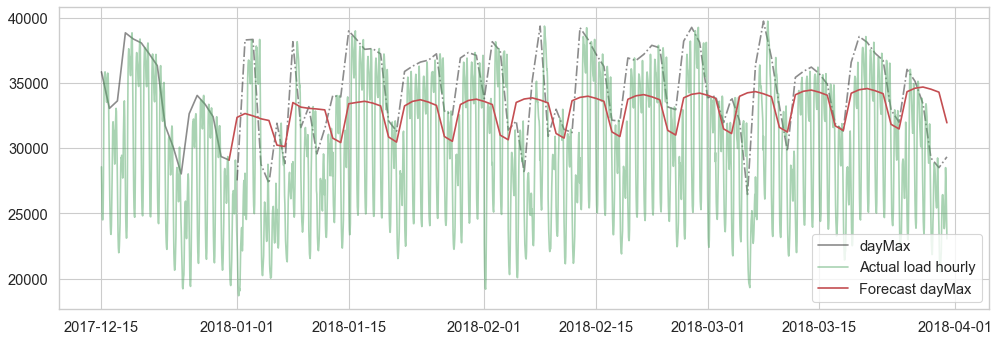

,y
ds,
2018-01-01,32372.286559
2018-01-02,32667.569992
2018-01-03,32488.288039
2018-01-04,32264.365494
2018-01-05,32133.540233


In [308]:
# Generate predictions [option 1]
forecast = results.forecast(forecast_period) #, exog=exog_test)

# date_range = pd.date_range(temp.index[-1], periods = forecast_period, 
#               freq='H').strftime("%Y-%m-%d-%H-%M-%S").tolist()

date_range = df_test.index #it is a datetime object


# Convert that date range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['ds'])
future_months['y'] = forecast.values
future_months.set_index('ds', inplace = True)


# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,5), dpi=80)


#plt.plot(results.predict().loc['2017-12-15':])
plt.plot(df_train[['y']].loc['2017-12-15':],'k',  alpha=0.5, label=dep_var)
plt.plot(df_test[['y']].loc[future_months.index],'k-.', alpha=0.5)
plt.plot(df['total load actual'].loc['2017-12-15':date_range[-1]],'g-', alpha=0.5, label= 'Actual load hourly')

# The forecast load
plt.plot(df_train[['y']].iloc[-1:].append(future_months[['y']]),'r-', label='Forecast '+dep_var)

plt.legend()
plt.show()

future_months.head()

* Generate predictions **(option 2)**

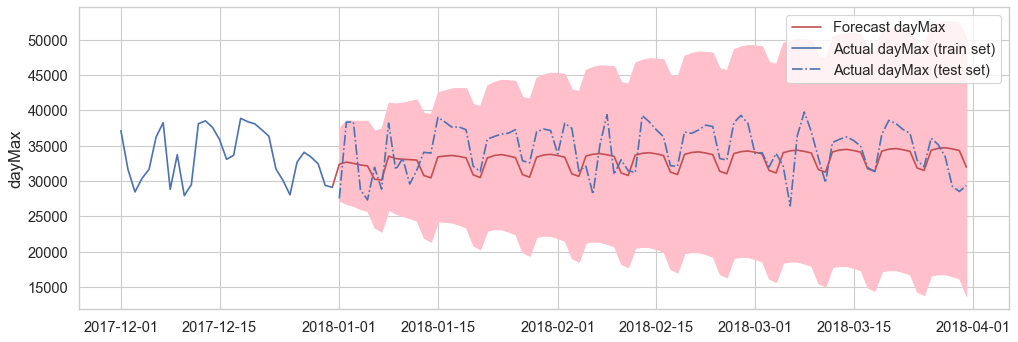

In [309]:
# Generate predictions [option 2]
dynamic_forecast = results.get_forecast(steps=forecast_period, dynamic=True, exog=exog_test)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean.values

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower y']
upper_limits = confidence_intervals.loc[:,'upper y']


fig, ax = plt.subplots(1,1, figsize=(15, 5), dpi=80)

# plot the mean forecast
ax.plot(df_train.index[-1:].append(date_range), 
        np.append(df_train[['y']].iloc[-1:].values, mean_forecast), 
        color='r', label='Forecast ' +dep_var)

# Shade the area between the confidence limits
ax.fill_between(df_test.index, lower_limits, 
         upper_limits, color='pink')

#df_train[['y']].loc['2017-12-1':].plot(style='k', ax=ax, label='Train')
ax.plot(df_train[['y']].loc['2017-12-1':],'b', label= 'Actual '+ dep_var + ' (train set)')
plt.plot(df_test['y'].loc[future_months.index],'-.', label='Actual '+ dep_var +' (test set)')

# set labels, legends and show plot
plt.xlabel('')
plt.ylabel(dep_var, fontsize=15)
plt.legend()


#plt.savefig('EDA_fig/DayMax_Forecast_noDailyUpdate.pdf',dpi=100, pad_inches=0.1, bbox_inches='tight')
plt.show()



### Save the trained model

In [310]:
## Save the trained model

# Set model name
filename = "enegy2_{}.pkl".format(dep_var)
print(filename)

# Pickle it
#joblib.dump(results, filename)

enegy2_dayMax.pkl


['enegy2_dayMax.pkl']

## Forecasting each day in the future (updating the pre-trained model with daily observation)

In [21]:
#SARIMAX.update(params,
def model_forecast(results, df_test):
    '''
    results - the fitted model
    '''
    # Declare a variable called forecast_period with the amount of months to forecast, and
    # create a range of future dates that is the length of the periods you've chosen to forecast

    date_range = df_test.index
    forecast_period = len(df_test)

    # Convert that range into a dataframe that includes your predictions
    future_pred = pd.DataFrame(date_range, columns=['ds'])

    # Let's now convert the 'Month' column to a datetime object with to_datetime
    future_pred['ds'] = pd.to_datetime(future_pred['ds'])
    future_pred.set_index('ds', inplace=True)

    # Generate predictions
    dynamic_forecast = results.get_forecast(
        steps=forecast_period, dynamic=True)
     #, exog=exog_test)
    #results.forecast(, dynamic=True)

    # Extract prediction mean
    mean_forecast = dynamic_forecast.predicted_mean.values
    future_pred['Prediction'] = mean_forecast

    # Get confidence intervals of predictions
    confidence_intervals = dynamic_forecast.conf_int()

    # Select lower and upper confidence limits
    future_pred['lower_limits'] = confidence_intervals.iloc[:, 0]
    future_pred['upper_limits'] = confidence_intervals.iloc[:, 1]

    #print(future_pred)
    return future_pred

In [22]:
# Creat a dict to store the dayMax, dayMin forecast
forcast_dict = {}


* Need to run the following 3 sections twice, w.r.t. two differnt `dep_var`.

In [25]:
# Initialize train and test sets
ind_var = 'time'
dep_var = 'dayMax' #'dayMin' #'smoothed_dayMin' #'smoothed_dayMax' #smoothed_dayMax
start_date = '2018-01-01'

df_train, df_test = train_test_split_by_time(ind_var, dep_var, forecast_start=start_date)

display(df_train.tail())
display(df_test.head())

,dayofweek,month,quarter,weekofyear,y
ds,,,,,
2017-12-27,2,12,4,52,34058.0
2017-12-28,3,12,4,52,33375.0
2017-12-29,4,12,4,52,32423.0
2017-12-30,5,12,4,52,29365.0
2017-12-31,6,12,4,52,29097.0


,dayofweek,month,quarter,weekofyear,y
ds,,,,,
2018-01-01,0,1,1,1,27534.0
2018-01-02,1,1,1,1,38313.0
2018-01-03,2,1,1,1,38355.0
2018-01-04,3,1,1,1,28770.0
2018-01-05,4,1,1,1,27316.0


In [26]:
# Load trained model
model_load = joblib.load("enegy_{}.pkl".format(dep_var))  
display(model_load)

In [356]:
print(model_load.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1096
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 7)   Log Likelihood               -9031.770
Date:                           Mon, 22 Nov 2021   AIC                          18085.541
Time:                                   18:38:59   BIC                          18140.454
Sample:                               01-01-2015   HQIC                         18106.326
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1236      0.025     -5.022      0.000      -0.172      -0.075
ar.L2         -0.4912      0.021    -23.291

In [27]:
# Initialize the prediction DataFrame
future_preds = pd.DataFrame(columns=['ds','Prediction', 'lower_limits', 'upper_limits'])
future_preds.set_index('ds', inplace=True)

print('Forecast', dep_var, 'for the next', len(df_test), 'days.')

for i in range(0, len(df_test)):
    # Forecasting day-by-day
    #exogs_1day = df_test[['trend']].iloc[:1]
    
    new_1day = df_test[['y']].iloc[:1].copy()
    
    future_1day = model_forecast(model_load, new_1day)
    future_preds = future_preds.append(future_1day)
    
    # update the model with extra one-day (24 hrs) actual observation
    model_load = model_load.extend(new_1day) #, exogenous = exogs_1day) 
    df_train = df_train.append(df_test.iloc[:1])
    df_test = df_test.iloc[1:]

future_preds = future_preds.join(df_train.loc[future_preds.index, ['y']])

# Save the results to dict
forcast_dict[dep_var] = future_preds.copy()

display(future_preds.shape)
display(future_preds.head())


Forecast dayMax for the next 365 days.


(365, 4)

,Prediction,lower_limits,upper_limits,y
ds,,,,
2018-01-01,30944.310725,25555.764315,36332.857136,27534.0
2018-01-02,30821.328756,25432.782346,36209.875167,38313.0
2018-01-03,37537.177412,32148.631002,42925.723823,38355.0
2018-01-04,35986.164601,30597.618190,41374.711011,28770.0
2018-01-05,29398.273973,24009.727562,34786.820383,27316.0


### Show the forecast results

In [358]:
iter_ind = (('dayMin','C0','skyblue'), ('dayMax','r','pink'))
#iter_ind = (('smoothed_dayMin','C0','skyblue'), ('smoothed_dayMax','r','pink'))

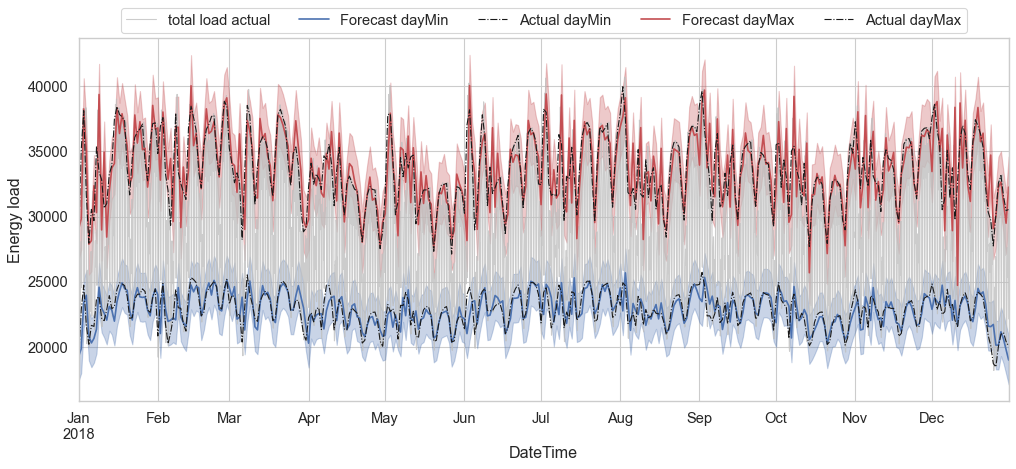

In [341]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=80)

# plot the hourly actual load
df[['total load actual']].loc[future_preds.index[0]:].plot(style='-',
                                                           color='silver', alpha=0.8,
                                                           linewidth=1,
                                                           ax=ax)

for i, (VarName, c1, c2) in enumerate(iter_ind):
    future_preds = forcast_dict[VarName]
    
    # plot the mean forecast
    future_preds['Prediction'].plot(color=c1,
                                    label='Forecast ' + VarName[-6:],
                                    ax=ax)

    # shade the area between the confidence limits
    ax.fill_between(future_preds.index,
                    future_preds['lower_limits'],
                    future_preds['upper_limits'],
                    color=c1,
                    alpha=0.3)
    
    # plot the true value
    future_preds['y'].loc[future_preds.index].plot(style='k-.',
                                                   linewidth=1,
                                                   label='Actual ' +
                                                   VarName[-6:],
                                                   ax=ax)

# set labels, legends and show plot
plt.xlabel('DateTime')
plt.ylabel('Energy load')
plt.legend()

ax.set_xlim(start_date, pd.Timestamp(future_preds.index[-1]))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.105),
          fancybox=True, shadow=False, ncol=5)

#plt.savefig('EDA_fig/Load_Forecast_2018.pdf',dpi=100, pad_inches=0.1, bbox_inches='tight')
plt.show()

### Residual autocorrelation plot

In [342]:
from scipy.stats import norm

Check the residuals and see wether the it has no significant autocorrelation, and is normally distributed.

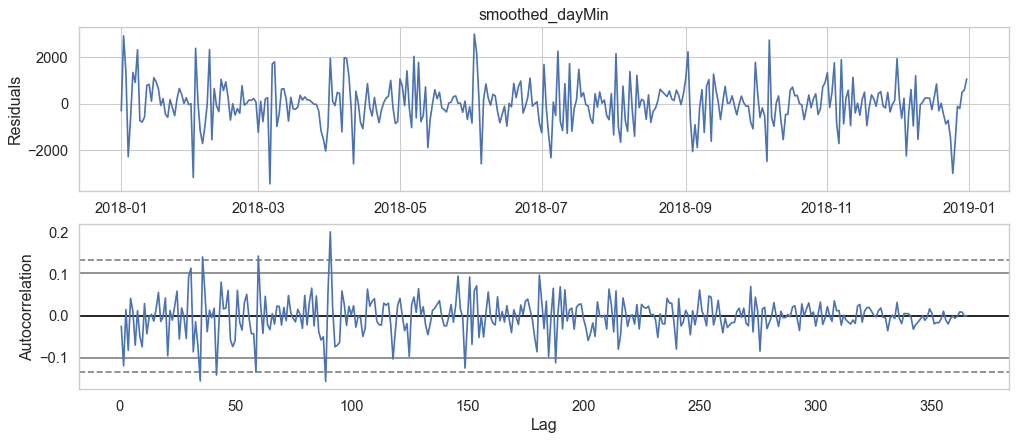

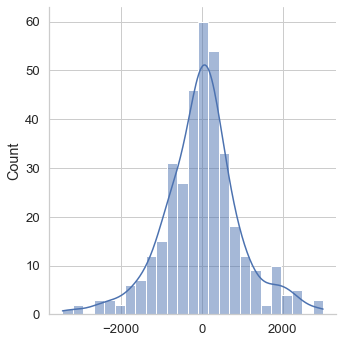

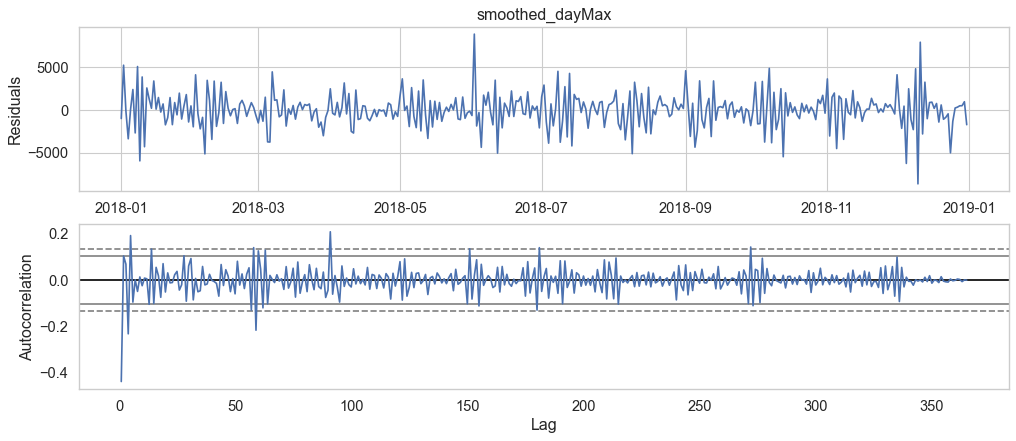

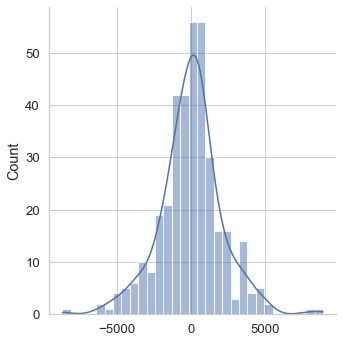

In [346]:
for i, (VarName, c1, c2) in enumerate(iter_ind):
    future_preds = forcast_dict[VarName]
    
    residuals = future_preds['y'] - future_preds['Prediction']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), dpi=80)
    ax1.plot(residuals)
    ax1.set_ylabel('Residuals')
    ax1.set_title(VarName)

    pd.plotting.autocorrelation_plot(residuals, ax=ax2)
    plt.savefig('EDA_fig/{}_residual.pdf'.format(VarName),dpi=100, pad_inches=0.1, bbox_inches='tight')
    plt.show()
    
    #_ = residuals.hist(bins=20)
    #plt.figure(figsize=(8,8))
    sns.displot(residuals, kde=True)
    plt.savefig('EDA_fig/{}_residual_hist.pdf'.format(VarName),dpi=100, pad_inches=0.1, bbox_inches='tight')
    
    plt.show()
    

### [backup] MAS, MSE, R-square

In [344]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import pearsonr

Var.: smoothed_dayMin
R-square (test): 0.485
MSE (test): 905257.994
MAE (test): 683.174
MAE percentage (test): 3.916%
Corr. = 0.725, p-value = 0.000




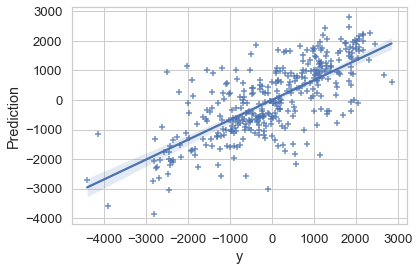

Var.: smoothed_dayMax
R-square (test): 0.404
MSE (test): 4334190.942
MAE (test): 1503.621
MAE percentage (test): 3.241%
Corr. = 0.726, p-value = 0.000




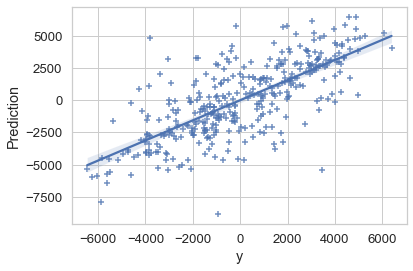

In [345]:
### R-square score (Coefficient of determination)
# y: the smoothed-dayMax / smoothed-dayMin

for i, (VarName, c1, c2) in enumerate(iter_ind):
    future_preds = forcast_dict[VarName]
    
    true_y = future_preds['y'] - np.mean(future_preds['y']) # Shift the data
    pred_y = future_preds['Prediction'] - np.mean(future_preds['y']) # Shift the data
    
    print('Var.:', VarName)
    print('R-square (test): {:.3f}'.format(r2_score(true_y, pred_y)))
    print('MSE (test): {:.3f}'.format( mean_squared_error(true_y, pred_y)))
    print('MAE (test): {:.3f}'.format(mean_absolute_error(true_y, pred_y)))
    print('MAE percentage (test): {:.3f}%'.format( mean_absolute_percentage_error(true_y, pred_y)))
    print('Corr. = %.3f, p-value = %.3f'%pearsonr(true_y, pred_y))
    print('\n')
    sns.regplot(x=true_y, y=pred_y, marker="+")
    plt.savefig('EDA_fig/{}_Forecast_Corr.pdf'.format(VarName),dpi=100, pad_inches=0.1, bbox_inches='tight')
    plt.show()

Var.: dayMin
R-square (test): 0.214
MSE (test): 1914869.977
MAE (test): 1011.081
MAE percentage (test): 2.041%
Corr. = 0.529, p-value = 0.000




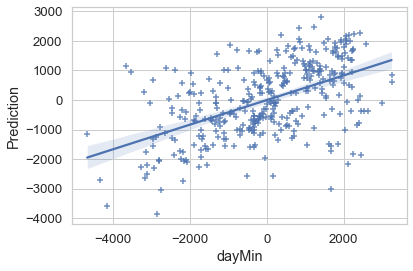

Var.: dayMax
R-square (test): 0.127
MSE (test): 8955130.535
MAE (test): 2213.290
MAE percentage (test): 3.978%
Corr. = 0.523, p-value = 0.000




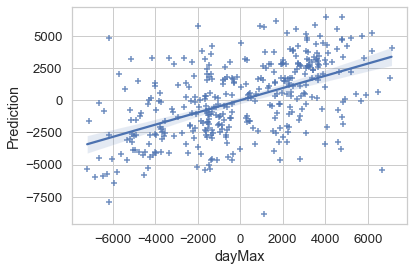

In [359]:
for i, (VarName, c1, c2) in enumerate(iter_ind):
    future_preds = forcast_dict[VarName]
    
    # y: the actual dayMax/dayMin
    true_y = df_train.loc[future_preds.index, VarName[-6:]]-np.mean(future_preds['Prediction'])
    pred_y = future_preds['Prediction']-np.mean(future_preds['Prediction'])
    
    print('Var.:', VarName[-6:])
    print('R-square (test): {:.3f}'.format(r2_score(true_y, pred_y)))
    print('MSE (test): {:.3f}'.format( mean_squared_error(true_y, pred_y)))
    print('MAE (test): {:.3f}'.format(mean_absolute_error(true_y, pred_y)))
    print('MAE percentage (test): {:.3f}%'.format( mean_absolute_percentage_error(true_y, pred_y)))
    print('Corr. = %.3f, p-value = %.3f'%pearsonr(true_y, pred_y))
    print('\n')
    sns.regplot(x=true_y, y=pred_y, marker="+")
    plt.show()